In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from datasets import load_dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [28]:
# Load the dataset
dataset = load_dataset('Amod/mental_health_counseling_conversations')

# Define a labeling function based on keywords
def label_response(example):
    positive_keywords = ["help", "support", "relief", "positive"]
    negative_keywords = ["stress", "anxiety", "depressed", "negative"]
    
    # Access the response and convert it to lowercase
    response = example["Response"].lower()
    
    # Assign labels based on keyword presence
    if any(word in response for word in positive_keywords):
        return 1  # Positive label
    elif any(word in response for word in negative_keywords):
        return 0  # Negative label
    else:
        return -1  # Neutral or undefined

# Apply labeling to the dataset
dataset = dataset.map(lambda x: {"label": label_response(x)})
# Optionally filter out neutral responses
dataset = dataset.filter(lambda x: x["label"] != -1)


Filter: 100%|██████████| 3512/3512 [00:00<00:00, 258432.53 examples/s]


In [30]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize function
def preprocess_data(examples):
    tokenized = tokenizer(examples["Response"], padding="max_length", truncation=True, max_length=128)
    tokenized["label"] = examples["label"]
    return tokenized

# Apply tokenization and formatting
dataset = dataset.map(preprocess_data, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map: 100%|██████████| 2346/2346 [00:00<00:00, 6582.42 examples/s]


In [31]:
# Define the split ratio
train_size = int(0.8 * len(dataset["train"]))
val_size = len(dataset["train"]) - train_size

# Perform the split
train_dataset, val_dataset = random_split(dataset["train"], [train_size, val_size])


In [32]:
batch_size = 32

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)


In [46]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # Embedding layer
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout, bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for bidirectional

    def forward(self, x):
        # x: (batch_size, sequence_length) -> embedding: (batch_size, sequence_length, embed_dim)
        x = self.embedding(x)
        batch_size = x.size(0)
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.n_layers * 2, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.n_layers * 2, batch_size, self.hidden_dim).to(x.device)
        
        # Forward pass through LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Concatenate the last forward and backward hidden states
        hn = torch.cat((lstm_out[:, -1, :self.hidden_dim], lstm_out[:, 0, self.hidden_dim:]), dim=1)
        hn = self.dropout(hn)
        out = self.fc(hn)
        
        return out


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
clip = 1.0
input_dim = 768  # Match BERT's hidden size
batch_size = 32



In [49]:
vocab_size = tokenizer.vocab_size  # Use the tokenizer's vocabulary size
embed_dim = 768  # Typically BERT's hidden dimension or any suitable embedding size

model = BiLSTMClassifier(vocab_size=vocab_size, embed_dim=embed_dim, hidden_dim=256, output_dim=1, n_layers=2, dropout=0.5).to(device)


In [50]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


In [52]:
for epoch in range(epochs):
    model.train()
    epoch_train_loss, epoch_train_correct, epoch_train_total = 0.0, 0, 0
    
    for batch in train_loader:
        # Ensure inputs are LongTensor for embedding lookup
        inputs = batch["input_ids"].long().to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        
        # Forward pass
        output = model(inputs)
        
        # Adjust output shape if necessary
        if output.dim() == 2 and output.shape[1] == 1:
            output = output.view(-1)
        labels = labels.view(-1)
        
        # Compute loss
        loss = criterion(output, labels.float())
        loss.backward()
        
        # Gradient clipping and optimizer step
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        # Accumulate loss and accuracy
        epoch_train_loss += loss.item()
        preds = torch.round(torch.sigmoid(output))
        epoch_train_correct += (preds == labels).sum().item()
        epoch_train_total += labels.size(0)
    
    # Calculate average training loss and accuracy
    train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = epoch_train_correct / epoch_train_total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    epoch_val_loss, epoch_val_correct, epoch_val_total = 0.0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            # Ensure inputs are LongTensor for embedding lookup
            inputs_v = batch["input_ids"].long().to(device)
            attention_mask_v = batch["attention_mask"].to(device)
            labels_v = batch["label"].to(device)
            
            output_v = model(inputs_v)
            
            if output_v.dim() == 2 and output_v.shape[1] == 1:
                output_v = output_v.view(-1)
            labels_v = labels_v.view(-1)
            
            val_loss = criterion(output_v, labels_v.float())
            epoch_val_loss += val_loss.item()
            preds_v = torch.round(torch.sigmoid(output_v))
            epoch_val_correct += (preds_v == labels_v).sum().item()
            epoch_val_total += labels_v.size(0)

    val_loss = epoch_val_loss / len(val_loader)
    val_accuracy = epoch_val_correct / epoch_val_total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")


Epoch 1/10 - Train Loss: 0.6830, Val Loss: 0.6830, Train Acc: 64.50%, Val Acc: 81.70%
Epoch 2/10 - Train Loss: 0.6849, Val Loss: 0.6830, Train Acc: 60.77%, Val Acc: 81.70%
Epoch 3/10 - Train Loss: 0.6845, Val Loss: 0.6830, Train Acc: 63.11%, Val Acc: 81.70%
Epoch 4/10 - Train Loss: 0.6833, Val Loss: 0.6830, Train Acc: 63.49%, Val Acc: 81.70%
Epoch 5/10 - Train Loss: 0.6835, Val Loss: 0.6830, Train Acc: 64.23%, Val Acc: 81.70%
Epoch 6/10 - Train Loss: 0.6840, Val Loss: 0.6830, Train Acc: 62.85%, Val Acc: 81.70%
Epoch 7/10 - Train Loss: 0.6839, Val Loss: 0.6830, Train Acc: 63.01%, Val Acc: 81.70%
Epoch 8/10 - Train Loss: 0.6830, Val Loss: 0.6830, Train Acc: 64.07%, Val Acc: 81.70%
Epoch 9/10 - Train Loss: 0.6837, Val Loss: 0.6830, Train Acc: 62.21%, Val Acc: 81.70%
Epoch 10/10 - Train Loss: 0.6845, Val Loss: 0.6830, Train Acc: 61.25%, Val Acc: 81.70%


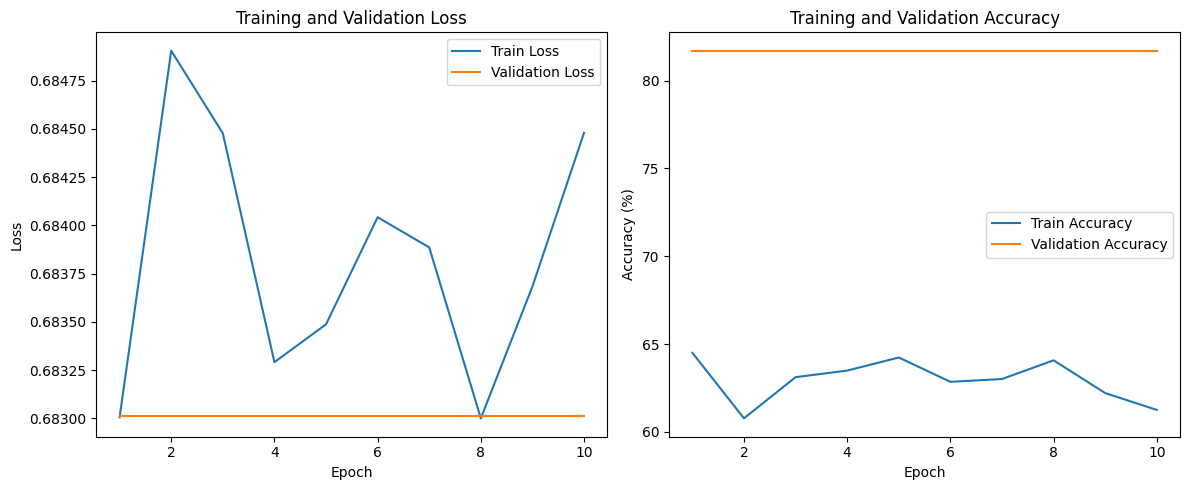

In [53]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
